# XGBoost trainer

This notebook function enables training and logging of xgboost models by exposing the higher level **[xgboost sklearn api](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)**.

For the **[low-level xgboost api](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)** please use **[xgb_custom.ipynb](../xgb_custom/xgb_custom.ipynb)**.



## steps
1. generate an xgboost model configuration by selecting one of 5 available types
2. get a sample of data from a data source (random rows, consecutive rows, or the entire dataset, custom sample)
3. split the data into train, validation, and test sets (WIP, this will be parametrized cross-validator)  
4. train the model using xgboost in one of its flavours (dask, gpu, mpi...)
5. dump the model
6. evaluate the model

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
from mlrun.mlutils import (get_sample, get_splits, gen_sklearn_model,
                           create_class, eval_model_v2, gcf_clear)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact, TableArtifact

from cloudpickle import dumps
import pandas as pd
import os
from typing import List

## generate an xgb model

generate a model config using the xgboost's sklearn api

In [4]:
def _gen_xgb_model(model_type: str, xgb_params: dict):
    """generate an xgboost model
    
    Multiple model types that can be estimated using
    the XGBoost Scikit-Learn API.
    
    Input can either be a predefined json model configuration or one
    of the five xgboost model types: "classifier", "regressor", "ranker",
    "rf_classifier", or "rf_regressor".
    
    In either case one can pass in a params dict to modify defaults values.
    
    Based on `mlutils.models.gen_sklearn_model`, see the function
    `sklearn_classifier` in this repository.
    
    :param model_type: one of "classifier", "regressor",
                       "ranker", "rf_classifier", or
                      "rf_regressor"
    :param xgb_params: class init parameters
    """
    # generate model and fit function
    mtypes = {
        "classifier"   : "xgboost.XGBClassifier",
        "regressor"    : "xgboost.XGBRegressor",
        "ranker"       : "xgboost.XGBRanker",
        "rf_classifier": "xgboost.XGBRFClassifier",
        "rf_regressor" : "xgboost.XGBRFRegressor"
    }
    if model_type.endswith("json"):
        model_config = model_type
    elif model_type in mtypes.keys():
        model_config = mtypes[model_type]
    else:
        raise Exception("unrecognized model type, see help documentation")

    return gen_sklearn_model(model_config, xgb_params)

## train

In [5]:
def train_model(
    context: MLClientCtx,
    model_type: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: dict = {},
    sample: int = -1,
    imbal_vec = [],
    test_size: float = 0.25,
    valid_size: float = 0.75,
    random_state: int = 1,
    models_dest: str = "models",
    plots_dest: str = "plots",
    eval_metrics: list= ["error", "auc"],
    file_ext: str = "parquet",
    model_pkg_file: str = "",    
) -> None:
    """train an xgboost model.
    
    Note on imabalanced data:  the `imbal_vec` parameter represents the measured
    class representations in the sample and can be used as a first step in tuning
    an XGBoost model.  This isn't a hyperparamter, merely an estimate that should
    be set as 'constant' throughout tuning process.
    
    :param context:           the function context
    :param model_type:        the model type to train, "classifier", "regressor"...
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param imbal_vec:         ([]) vector of class weights seen in sample
    :param test_size:         (0.05) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param eval_metrics:      (["error", "auc"]) learning curve metrics
    :param file_ext:          format for test_set_key hold out data
    """
    # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, valid_size, random_state)
    
    # save test data
    context.log_dataset("test-set", df=pd.concat([xtest, ytest], axis=1), format=file_ext, index=False)

    # get model config
    model_config = _gen_xgb_model(model_type, context.parameters.items())

    # create model instance
    XGBBoostClass = create_class(model_config["META"]["class"])
    model = XGBBoostClass(**model_config["CLASS"])

    # update the model config with training data and callbacks
    model_config["FIT"].update({"X": xtrain, 
                                "y": ytrain.values,
                                "eval_set":[(xtrain, ytrain), (xvalid, yvalid)],
                                "eval_metric": eval_metrics})

    # run the fit
    model.fit(**model_config["FIT"])

    # evaluate model
    eval_metrics = eval_model_v2(context, xvalid, yvalid, model)

    # just do this inside log_model?
    if hasattr(eval_metrics, "plots"):
        model_plots = eval_metrics.pop("plots")
        for plot in model_plots:
            context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")
    if hasattr(eval_metrics, "tables"):
        model_tables = eval_metrics.pop("tables")
        for tbl in model_tables:
            context.log_artifact(tbl, local_path=f"{plots_dest}/{plot.key}.csv")

    model_bin = dumps(model)
#     context.log_model("model", body=model_bin,
#                       artifact_path=os.path.join(context.artifact_path, models_dest),
#                       #model_dir=models_dest, 
#                       model_file="model.pkl",
#                       metrics=eval_metrics)

In [6]:
# nuclio: end-code

### save

In [7]:
from mlrun import code_to_function
from mlrun.platforms.other import auto_mount

# create job function object from notebook code
fn = code_to_function(
    name="xgb_trainer",
    handler="train_model",
    kind="job",
    image="mlrun/ml-models",
    description="train multiple model types using xgboost",
    categories=["training", "ml", "experimental"],
    labels={"author": "yjb", "framework": "xgboost"}
)

fn.export("function.yaml")
fn.apply(auto_mount())

[mlrun] 2020-06-08 02:06:02,763 function spec saved to path: function.yaml


### test function

In [8]:
gpus = False

task_params = {
    "name" : "tasks xgb cpu trainer",
    "params" : {
        "model_type"              : "classifier",
        "CLASS_tree_method"       : "gpu_hist" if gpus else "hist",
        "CLASS_objective"         : "binary:logistic",
        "CLASS_booster"           : "gbtree",
        "FIT_verbose"             : 0,
        "imbal_vec"               : [],
        "label_column"            : "labels"}}

### run locally

In [9]:
DATA_URL = "https://raw.githubusercontent.com/yjb-ds/testdata/master/data/classifier-data.csv"

[mlrun] 2020-06-08 02:06:10,848 starting run tasks xgb cpu trainer uid=5bfbd73f91e34b8796bf959e45804eb5  -> http://mlrun-api:8080
[mlrun] 2020-06-08 02:06:11,175 log artifact test-set at /User/artifacts/test-set.parquet, size: 8143, db: Y
[mlrun] 2020-06-08 02:06:12,028 log artifact probability-calibration at /User/artifacts/plots/probability-calibration.html, size: 29998, db: N
[mlrun] 2020-06-08 02:06:12,129 log artifact confusion-matrix at /User/artifacts/plots/confusion-matrix.html, size: 10673, db: N
[mlrun] 2020-06-08 02:06:12,291 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 7977, db: N
[mlrun] 2020-06-08 02:06:12,455 log artifact precision-recall-binary at /User/artifacts/plots/precision-recall-binary.html, size: 13269, db: N
[mlrun] 2020-06-08 02:06:12,565 log artifact roc-binary at /User/artifacts/plots/roc-binary.html, size: 17989, db: N



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...45804eb5,0,Jun 08 02:06:10,completed,tasks xgb cpu trainer,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-kdb7x,dataset,model_type=classifierCLASS_tree_method=histCLASS_objective=binary:logisticCLASS_booster=gbtreeFIT_verbose=0imbal_vec=[]label_column=labels,test-accuracy=0.9323843416370107test-error=0.06761565836298933rocauc=0.9659365479567182brier_score=0.056567031556114825f1-score=0.9155555555555556precision_score=0.9279279279279279recall_score=0.9035087719298246,test-setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binary


to track results use .show() or .logs() or in CLI: 
!mlrun get run 5bfbd73f91e34b8796bf959e45804eb5 --project default , !mlrun logs 5bfbd73f91e34b8796bf959e45804eb5 --project default
[mlrun] 2020-06-08 02:06:12,637 run executed, status=completed


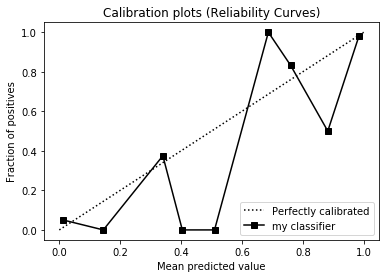

<Figure size 432x288 with 0 Axes>

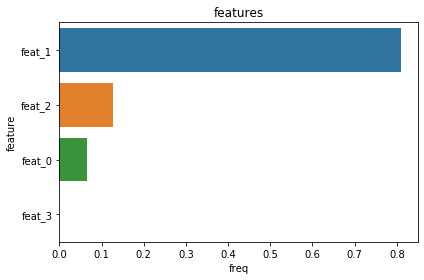

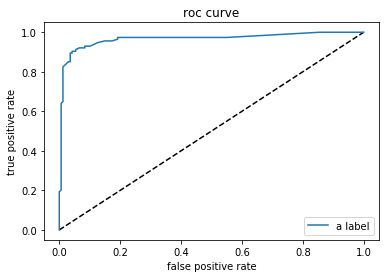

In [11]:
from mlrun import run_local, NewTask, mlconf

run = run_local(
    NewTask(**task_params),
    handler=train_model,
    inputs={"dataset"  : DATA_URL},
    artifact_path=mlconf.artifact_path)